# Supervised learning - Classification
Goal of this excercise is to complete the hands-on experience task with similar task description as in the classification project case.

We will use the modified Household Prices Dataset.

Data source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Important attributes description:
* SalePrice: The property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* Heating: Type of heating
* CentralAir: Central air conditioning
* GrLivArea: Above grade (ground) living area square feet
* BedroomAbvGr: Number of bedrooms above basement level)

### Complete the following tasks:
1. **Describe what operations you are performing for each of the features**
    - Mainly focus on categorical features
2. Answer the following questions:
    - **How many values are missing?**
    - **How many instances do you have in each of the classes?**
    - **Which metric score do you propose for the classification model performance evaluation?**
        - Hint: This depends on your previous answer
3. Finish your preprocessing pipeline and split the data into the Input and Output part (i.e. X and y variables)
4. Start with the Decision tree model
    - Use 5-fold cross validation
    - **Will you use *standard* cross validation or *stratified* cross validation? Why?**
    - Compute mean of the obtained score values
5. Select one other algorithm from https://scikit-learn.org/stable/supervised_learning.html
    - Repeat the 5-fold CV
6. **Write down which model is better and why**
7. Do **5 experiments** with hyper-parameters
    - Set the parameters
    - Do the 5-fold CV
    - Note the settings and score in the Markdown cell
8. **Write down  which model is the best and why**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, auc
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer, MinMaxScaler

## We will use categorized price as a target variable
- Our goal is to predict if the house will be sold for more than 250k USD or not

In [2]:
df = pd.read_csv('mad3_cv1_data.csv').loc[:, ['SalePrice','MSSubClass','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','Heating','CentralAir','GrLivArea','BedroomAbvGr']]
df.loc[:, 'Target'] = (df.SalePrice > 250000).astype(int)
df = df.drop(['SalePrice'], axis=1)

In [3]:
df.head()

,MSSubClass,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,Heating,CentralAir,GrLivArea,BedroomAbvGr,Target
0,60,1Fam,2Story,7,5,2003,GasA,Y,1710,3,0
1,20,1Fam,1Story,6,8,1976,GasA,Y,1262,3,0
2,60,1Fam,2Story,7,5,2001,GasA,Y,1786,3,0
3,70,1Fam,2Story,7,5,1915,GasA,Y,1717,3,0
4,60,1Fam,2Story,8,5,2000,GasA,Y,2198,4,0


## Take a look at the features

In [4]:
df_numerical = df.select_dtypes(np.number)

In [5]:
df_numerical.describe()

,MSSubClass,OverallQual,OverallCond,YearBuilt,GrLivArea,BedroomAbvGr,Target
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,6.099315,5.575342,1971.267808,1515.463699,2.866438,0.148630
std,42.300571,1.382997,1.112799,30.202904,525.480383,0.815778,0.355845
min,20.000000,1.000000,1.000000,1872.000000,334.000000,0.000000,0.000000
25%,20.000000,5.000000,5.000000,1954.000000,1129.500000,2.000000,0.000000
50%,50.000000,6.000000,5.000000,1973.000000,1464.000000,3.000000,0.000000
75%,70.000000,7.000000,6.000000,2000.000000,1776.750000,3.000000,0.000000
max,190.000000,10.000000,9.000000,2010.000000,5642.000000,8.000000,1.000000


c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

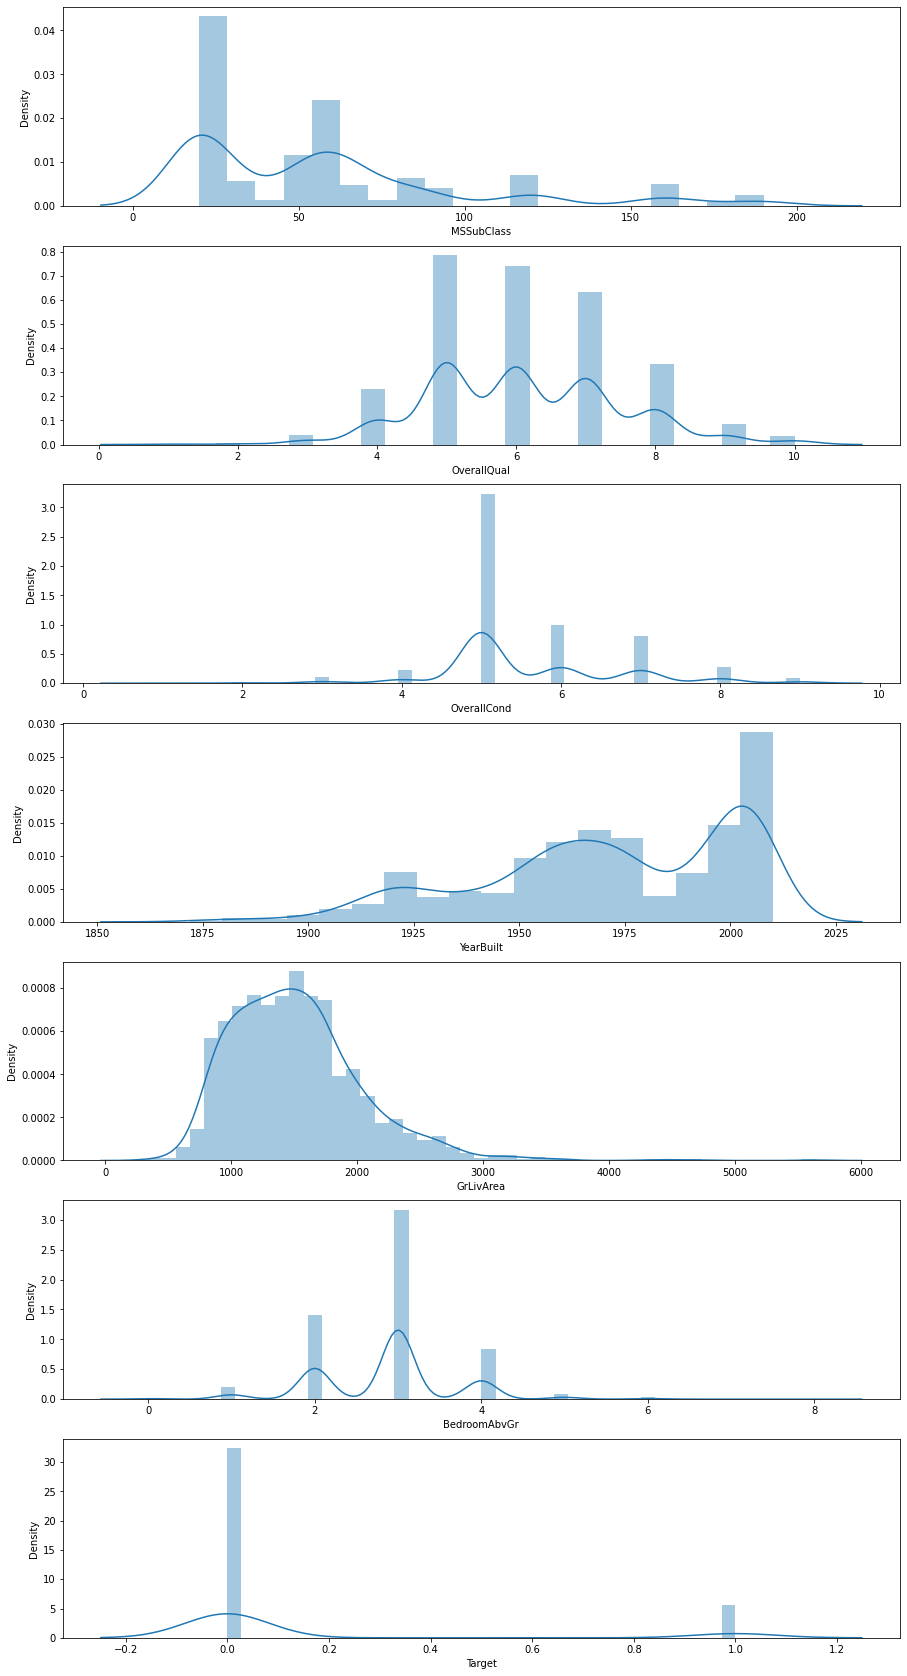

In [6]:
fig, axes = plt.subplots(df_numerical.shape[1], 1, figsize=(15, 30))

for ax, col in zip(axes, df_numerical.columns):
    sns.distplot(df_numerical[col], ax=ax, axlabel=col)

In [7]:
df.describe(exclude=np.number)

,BldgType,HouseStyle,Heating,CentralAir
count,1460,1460,1460,1460
unique,5,8,6,2
top,1Fam,1Story,GasA,Y
freq,1220,726,1428,1365


In [8]:
df.BldgType.unique()

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

In [9]:
df.HouseStyle.unique()

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

In [10]:
df.Heating.unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

Not a single categorical feature is 100% ordinal, therefore we will use One hot encoding for them.

## Do we have some missing values?

In [11]:
df.isna().sum()

MSSubClass      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
Heating         0
CentralAir      0
GrLivArea       0
BedroomAbvGr    0
Target          0
dtype: int64

In [12]:
df.shape

(1460, 11)

## Preprocessing

In [13]:
preprocessing = StandardScaler()
df_preprocess = pd.DataFrame(preprocessing.fit_transform(df_numerical), columns=df_numerical.columns)
df_preprocess.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,GrLivArea,BedroomAbvGr,Target
0,0.073375,0.651479,-0.517200,1.050994,0.370333,0.163779,-0.417825
1,-0.872563,-0.071836,2.179628,0.156734,-0.482512,0.163779,-0.417825
2,0.073375,0.651479,-0.517200,0.984752,0.515013,0.163779,-0.417825
3,0.309859,0.651479,-0.517200,-1.863632,0.383659,0.163779,-0.417825
4,0.073375,1.374795,-0.517200,0.951632,1.299326,1.390023,-0.417825


In [14]:
df_preprocess = df_preprocess.join(pd.get_dummies(df[['BldgType', 'HouseStyle', 'Heating', 'CentralAir']]))
df_preprocess.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,GrLivArea,BedroomAbvGr,Target,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,HouseStyle_SFoyer,HouseStyle_SLvl,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y
0,0.073375,0.651479,-0.517200,1.050994,0.370333,0.163779,-0.417825,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,-0.872563,-0.071836,2.179628,0.156734,-0.482512,0.163779,-0.417825,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.073375,0.651479,-0.517200,0.984752,0.515013,0.163779,-0.417825,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.309859,0.651479,-0.517200,-1.863632,0.383659,0.163779,-0.417825,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.073375,1.374795,-0.517200,0.951632,1.299326,1.390023,-0.417825,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [15]:
X = df_preprocess.drop('Target', axis=1)
X.shape

(1460, 27)

In [16]:
y = df.Target
y.shape

(1460,)

In [17]:
y.value_counts()

0    1243
1     217
Name: Target, dtype: int64

## Decision tree

In [19]:
def evaluate_classifier(clf, X, y):
    skf = StratifiedKFold(n_splits=5)
    scores = list()
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(f1_score(y_test, y_pred))

    return np.mean(scores), np.std(scores), scores

In [20]:
clf = DecisionTreeClassifier()
evaluate_classifier(clf, X, y)

(0.6960410902733001,
 0.06252070302774713,
 [0.6593406593406593,
  0.7857142857142858,
  0.6,
  0.7191011235955056,
  0.7160493827160493])

In [27]:
#dochází k přeučení když není omezený na maximální hloubku | porovnání s předchozím
clf = DecisionTreeClassifier(max_depth=4)
evaluate_classifier(clf, X, y)

(0.734240782101194,
 0.06554986364343286,
 [0.6739130434782609,
  0.7894736842105263,
  0.7749999999999999,
  0.7954545454545455,
  0.6373626373626374])

## Random forest 

- každý strom pracuje s jinými atributy (každý strom se vytvoří jinak)
- každý to vyhodnotí, a vezme se nejčetnější výsledek

In [22]:
clf = RandomForestClassifier(n_estimators=50)
evaluate_classifier(clf, X, y)

(0.7480796884076603,
 0.05268576578537835,
 [0.7126436781609196,
  0.8235294117647058,
  0.7042253521126761,
  0.7999999999999999,
  0.7000000000000001])

<AxesSubplot:>

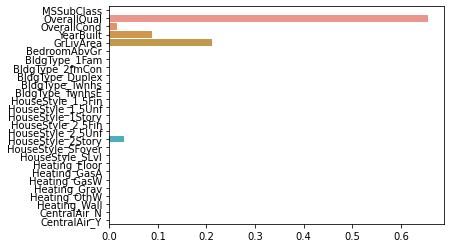

In [28]:
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [31]:
clf = RandomForestClassifier(n_estimators=50)
evaluate_classifier(clf, X, y)

(0.7577302988949576,
 0.04301040822447893,
 [0.7045454545454545,
  0.8192771084337349,
  0.7567567567567568,
  0.7901234567901235,
  0.717948717948718])

In [33]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5)
evaluate_classifier(clf, X, y)

(0.7472328888029613,
 0.049234987489238,
 [0.6923076923076923,
  0.7733333333333334,
  0.7323943661971831,
  0.8292682926829269,
  0.7088607594936709])

## AdaBoost

- Boosting, přidává váhu těm které mi předtím nešli

In [34]:
clf = AdaBoostClassifier(n_estimators=10)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.7294726522907097,
 0.03373218726917604,
 [0.6818181818181818,
  0.7012987012987012,
  0.7435897435897435,
  0.7764705882352942,
  0.7441860465116279])

In [35]:
clf = AdaBoostClassifier(n_estimators=50)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.7792565340797555,
 0.0382938138539665,
 [0.7380952380952381,
  0.8148148148148148,
  0.7341772151898734,
  0.8275862068965518,
  0.7816091954022988])

In [36]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2) , n_estimators=50)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.7336845767994347,
 0.057195934811583714,
 [0.6744186046511628,
  0.8275862068965518,
  0.6829268292682927,
  0.7674418604651163,
  0.7160493827160493])

In [37]:
clf = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=10)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.5889647960525493,
 0.06459455656074403,
 [0.46428571428571425,
  0.6363636363636364,
  0.5901639344262295,
  0.6363636363636365,
  0.6176470588235294])

In [39]:
clf = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=50)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.6946156416682733,
 0.030419246410020775,
 [0.6388888888888888,
  0.72,
  0.6857142857142857,
  0.717948717948718,
  0.7105263157894737])

## Gradient boosting trees

In [40]:
clf = HistGradientBoostingClassifier()
evaluate_classifier(clf, X, y)

(0.7553414193281534,
 0.048522564495609564,
 [0.7058823529411765,
  0.8275862068965518,
  0.7407407407407408,
  0.7951807228915662,
  0.7073170731707317])

## K-NN classifier

In [41]:
clf = KNeighborsClassifier(n_neighbors=10)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have val

(0.7389676723454205,
 0.05847427868851093,
 [0.6666666666666666,
  0.7894736842105263,
  0.7532467532467532,
  0.810126582278481,
  0.6753246753246752])

## Stacking

In [42]:
clf = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=10)),
        ('dt', DecisionTreeClassifier(max_depth=5)),
        ('ada', AdaBoostClassifier(n_estimators=10))
    ]
)
evaluate_classifier(clf, X, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid featu

(0.7370676597885488,
 0.048051006098329366,
 [0.7126436781609196,
  0.8048780487804877,
  0.7123287671232877,
  0.7804878048780488,
  0.6749999999999999])

## Preprocessing 2

In [43]:
preprocessing = MinMaxScaler()
df_preprocess2 = pd.DataFrame(preprocessing.fit_transform(df_numerical), columns=df_numerical.columns)
df_preprocess2 = df_preprocess2.join(pd.get_dummies(df[['BldgType', 'HouseStyle', 'Heating', 'CentralAir']]))
df_preprocess2.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,GrLivArea,BedroomAbvGr,Target,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,HouseStyle_SFoyer,HouseStyle_SLvl,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y
0,0.235294,0.666667,0.500,0.949275,0.259231,0.375,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.000000,0.555556,0.875,0.753623,0.174830,0.375,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.235294,0.666667,0.500,0.934783,0.273549,0.375,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.294118,0.666667,0.500,0.311594,0.260550,0.375,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.235294,0.777778,0.500,0.927536,0.351168,0.500,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [44]:
X2 = df_preprocess2.drop('Target', axis=1)
X2.shape

(1460, 27)

In [45]:
y = df.Target
y.shape

(1460,)

In [46]:
clf = KNeighborsClassifier(n_neighbors=10)
evaluate_classifier(clf, X2, y)

c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\proko\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have val

(0.7055763938921833,
 0.056558151744468654,
 [0.6753246753246753,
  0.7733333333333334,
  0.6944444444444445,
  0.763157894736842,
  0.6216216216216216])